In [3]:
! pip install mordred
! pip install pubchempy
! pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("data_compound.csv")
#df = df.drop_duplicates(ignore_index=True)
df

,sid,cid,smiles,activity,type,value (nM)
0,316936203,118159182,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066
1,316936247,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083
2,316936221,118159272,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085
3,316936228,118159276,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088
4,316936201,118159362,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091
...,...,...,...,...,...,...
1629,336857410,9966680,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1630,336857410,9966680,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1631,336857473,4526747,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000
1632,336857473,4526747,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000


In [6]:
df['activity'].value_counts()

Active         1053
Inactive        304
Unspecified     277
Name: activity, dtype: int64

In [7]:
df_hist = df[['smiles','activity', 'type', 'value (nM)']]
df_hist

,smiles,activity,type,value (nM)
0,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066
1,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083
2,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085
3,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088
4,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091
...,...,...,...,...
1629,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1630,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1631,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000
1632,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000


In [8]:
IC50_only = df_hist[df_hist['type']=='IC50'].reset_index(drop=True)
IC50_only['pIC50'] = 9 - np.log10(IC50_only['value (nM)'])
IC50_only = IC50_only.drop_duplicates(keep='first', ignore_index=True)
IC50_only

,smiles,activity,type,value (nM),pIC50
0,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066,11.180456
1,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083,11.080922
2,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085,11.070581
3,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088,11.055517
4,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091,11.040959
...,...,...,...,...,...
761,CC(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCN(CC3)CC4=C(C=...,Unspecified,IC50,97800.0000,4.009661
762,CC1C2=C(CCN1S(=O)(=O)C)N=C(C(=N2)N3CCC(CC3)OC4...,Unspecified,IC50,98000.0000,4.008774
763,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC3=CC=CC=C3C=C2,Unspecified,IC50,100000.0000,4.000000
764,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000,4.000000


In [9]:
IC50_only.to_csv('IC50_gpr6_substance.csv')

c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

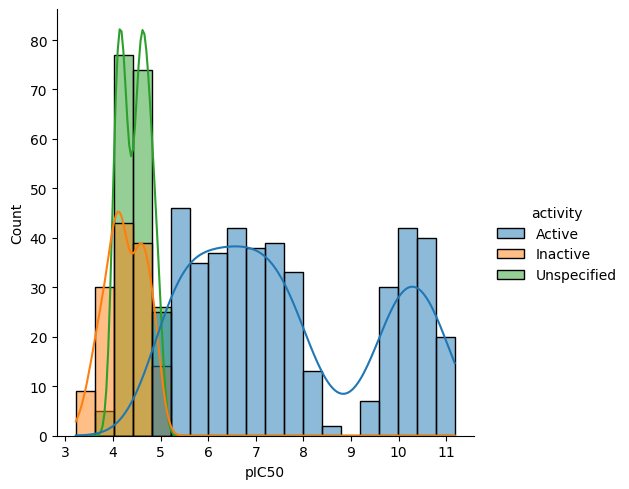

In [10]:
plt.figure(figsize=(20, 20))

sns.displot(IC50_only, bins=20, x='pIC50', hue='activity', kde=True)
plt.show()

In [11]:
def canonical_smiles(smiles):
    mol_smiles = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mol_smiles]

    return smiles

In [12]:
CANNO_SMILES = canonical_smiles(IC50_only.smiles)
len(CANNO_SMILES)

766

In [13]:
IC50_only['smiles'] = CANNO_SMILES
IC50_only

,smiles,activity,type,value (nM),pIC50
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,11.180456
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,11.080922
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,11.070581
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,11.055517
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,11.040959
...,...,...,...,...,...
761,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(F)cc4F)CC3)c(N[C@H...,Unspecified,IC50,97800.0000,4.009661
762,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,4.008774
763,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,4.000000
764,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,4.000000


In [14]:
smiles_list = list(IC50_only["smiles"])
smiles_list

['CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CN(C)CC2',
 'CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CN1CCc2nc(NC3CC3)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(=O)N(C)C)C2',
 'CC1Cc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2CN1S(C)(=O)=O',
 'CC(C)Nc1nc2c(nc1N1CCC([C@H](F)c3ccc(F)cc3F)CC1)CCN(C=O)C2',
 'CC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'COc1ccc(OC2CCN(c3nc4c(nc3NC3CCC3)CCN(C(C)=O)C4)CC2)c(F)c1',
 'CC(=O)N1CCc2nc(N3CCC(C(F)c4ccc(F)cc4F)CC3)c(NC(C)C)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CCN(C)C2',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=O)N(C)C)CC2C',
 'CC(=O)N1CCc

**RDkit Descriptor**

In [ ]:
smiles2 = [Chem.MolFromSmiles(i) for i in smiles_list]
mols2 = [m for m in smiles2]
len(mols2)

766

In [ ]:
alldesc = [Descriptors.CalcMolDescriptors(m) for m in mols2]
rdkit_gpr6 = pd.DataFrame(alldesc)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
1,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
2,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,166,0,...,0,0,0,0,0,0,0,0,0,0
4,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,190,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,14.093085,14.093085,0.045316,-0.559103,0.715212,472.540,442.300,472.239831,182,0,...,0,0,0,0,0,0,0,0,0,0
762,13.985168,13.985168,0.046553,-3.362224,0.656323,495.596,464.348,495.211567,186,0,...,0,1,0,0,0,0,0,0,0,0
763,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0
764,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#df_gpr6_compound = df.join(df_descrs)
#df_gpr6_compound

In [ ]:
df_smiles = IC50_only[['smiles', 'activity']]
df_merged_smiles_rdkit = df_smiles.join(rdkit_gpr6)
df_merged_smiles_rdkit

,smiles,activity,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,...,0,0,0,0,0,0,0,0,0,0
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,...,0,0,0,0,0,0,0,0,0,0
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(F)cc4F)CC3)c(N[C@H...,Unspecified,14.093085,14.093085,0.045316,-0.559103,0.715212,472.540,442.300,472.239831,...,0,0,0,0,0,0,0,0,0,0
762,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,13.985168,13.985168,0.046553,-3.362224,0.656323,495.596,464.348,495.211567,...,0,1,0,0,0,0,0,0,0,0
763,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0
764,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#df_merged_smiles_rdkit.to_csv("rdkit_descriptors_gpr6.csv", index=False)

**Mordred Descriptors**

In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    smiles3 = [Chem.MolFromSmiles(i) for i in data]
    
    df_mordred = calc.pandas(smiles3)
    return df_mordred

In [ ]:
mordred_gpr6 = All_Mordred_descriptors(smiles_list)
mordred_gpr6.shape


(766, 1613)

In [ ]:
mordred_gpr6

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,25.938492,19.114455,0,0,41.715306,2.464737,4.929475,41.715306,1.2641,4.426747,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,24.455329,18.151364,0,1,39.965051,2.458558,4.917115,39.965051,1.289195,4.367884,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,27.393146,19.733756,0,0,44.686795,2.462679,4.925359,44.686795,1.276766,4.479689,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,27.105416,19.386298,0,1,44.575291,2.465083,4.926814,44.575291,1.311038,4.469451,...,10.469852,83.609016,472.239831,7.378747,3718,54,184.0,217.0,9.833333,7.305556
762,26.882406,19.827162,0,0,42.133369,2.501032,5.002063,42.133369,1.239217,4.458711,...,10.573238,70.701159,495.211567,7.618639,3642,58,184.0,217.0,12.645833,7.166667
763,16.429865,13.664452,0,0,27.401028,2.384287,4.759565,27.401028,1.304811,3.980697,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
764,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,1.305464,3.980899,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889


In [ ]:
df_merged_smiles_mordred = IC50_only.join(mordred_gpr6)
df_merged_smiles_mordred

,smiles,activity,type,value (nM),pIC50,Structure,ABC,ABCGG,nAcid,nBase,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,11.180456,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,27.990863,20.208094,0,0,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,11.080922,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,27.990863,20.208094,0,0,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,11.070581,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,25.938492,19.114455,0,0,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,11.055517,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,24.455329,18.151364,0,1,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,11.040959,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,27.393146,19.733756,0,0,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(F)cc4F)CC3)c(N[C@H...,Unspecified,IC50,97800.0000,4.009661,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,27.105416,19.386298,0,1,...,10.469852,83.609016,472.239831,7.378747,3718,54,184.0,217.0,9.833333,7.305556
762,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,4.008774,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,26.882406,19.827162,0,0,...,10.573238,70.701159,495.211567,7.618639,3642,58,184.0,217.0,12.645833,7.166667
763,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.429865,13.664452,0,0,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
764,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.389425,13.970163,0,0,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889


In [ ]:
#df_merged_smiles_mordred.to_csv("mordred_descriptors_gpr6.csv", index=False)

**Data Preprocessing**

In [ ]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.0,...,766.000000,766.000000,766.000000,766.0,766.0,766.0,766.0,766.000000,766.000000,766.000000
mean,13.608263,13.608263,0.111642,-2.620311,0.583897,487.949184,461.368785,487.521620,182.697128,0.0,...,0.005222,0.071802,0.016971,0.0,0.0,0.0,0.0,0.016971,0.019582,0.091384
std,1.331949,1.331949,0.141837,2.025857,0.135222,80.948308,77.278319,80.875661,32.900399,0.0,...,0.072121,0.258328,0.129248,0.0,0.0,0.0,0.0,0.129248,0.147778,0.288342
min,4.871601,4.871601,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,13.716346,13.716346,0.029579,-5.083333,0.469566,457.550000,426.406750,457.248918,174.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,13.972664,13.972664,0.056497,-2.562425,0.610726,495.521000,464.348000,495.211567,190.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,14.154230,14.154230,0.117634,-0.682009,0.696577,534.202250,510.050750,533.917320,198.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.791107,0.716349,0.802254,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,1.000000


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

In [ ]:
x = scaler.fit_transform(rdkit_gpr6)
x

array([[ 0.27346069,  0.27346069, -0.67499289, ..., -0.13139359,
        -0.13259806, -0.31713516],
       [ 0.27346069,  0.27346069, -0.67499289, ..., -0.13139359,
        -0.13259806, -0.31713516],
       [ 1.10507906,  1.10507906, -0.71440542, ..., -0.13139359,
        -0.13259806, -0.31713516],
       ...,
       [-1.00298918, -1.00298918,  0.77717988, ..., -0.13139359,
        -0.13259806, -0.31713516],
       [-0.87505006, -0.87505006,  0.73767906, ..., -0.13139359,
        -0.13259806, -0.31713516],
       [-1.33631871, -1.33631871,  0.7455179 , ..., -0.13139359,
        -0.13259806, -0.31713516]])

In [ ]:
rdkit_standardized = pd.DataFrame(x, columns=rdkit_gpr6.columns)
rdkit_standardized

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.273461,0.273461,-0.674993,0.026986,-0.291108,0.291374,0.270877,0.293222,0.404602,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
1,0.273461,0.273461,-0.674993,0.026986,-0.291108,0.291374,0.270877,0.293222,0.404602,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
2,1.105079,1.105079,-0.714405,0.560114,0.970331,-0.326560,-0.389455,-0.325173,-0.142861,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
3,0.416406,0.416406,-0.168863,1.042700,0.833841,-0.518931,-0.577910,-0.523579,-0.507837,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
4,0.260039,0.260039,-0.711606,0.031358,0.248216,0.105813,0.089556,0.107635,0.222114,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,3.153230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.364232,0.364232,-0.467923,1.018115,0.971744,-0.190483,-0.246916,-0.189078,-0.021203,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
762,0.283157,0.283157,-0.459201,-0.366461,0.535959,0.094527,0.038577,0.095146,0.100456,0.0,...,-0.072452,3.595452,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
763,-1.002989,-1.002989,0.777180,1.184721,1.515488,-2.132706,-2.059487,-2.133946,-2.332715,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135
764,-0.875050,-0.875050,0.737679,1.187487,1.515488,-2.132706,-2.059487,-2.133946,-2.332715,0.0,...,-0.072452,-0.278129,-0.131394,0.0,0.0,0.0,0.0,-0.131394,-0.132598,-0.317135


In [ ]:
rdkit_standardized.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,7.660000e+02,766.0,...,7.660000e+02,7.660000e+02,7.660000e+02,766.0,766.0,766.0,766.0,7.660000e+02,7.660000e+02,7.660000e+02
mean,-1.252262e-15,-1.252262e-15,2.782804e-17,-6.493210e-17,2.226244e-16,-7.420812e-17,-5.565609e-17,5.287328e-16,3.710406e-16,0.0,...,-1.391402e-17,4.638007e-18,-1.623303e-17,0.0,0.0,0.0,0.0,-1.623303e-17,5.449659e-17,-4.638007e-17
std,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,1.000653e+00,0.0,...,1.000653e+00,1.000653e+00,1.000653e+00,0.0,0.0,0.0,0.0,1.000653e+00,1.000653e+00,1.000653e+00
min,-6.563591e+00,-6.563591e+00,-7.876287e-01,-1.216587e+00,-2.522627e+00,-2.900549e+00,-2.785482e+00,-2.901700e+00,-3.062666e+00,0.0,...,-7.245236e-02,-2.781292e-01,-1.313936e-01,0.0,0.0,0.0,0.0,-1.313936e-01,-1.325981e-01,-3.171352e-01
25%,8.119941e-02,8.119941e-02,-5.789501e-01,-1.216587e+00,-8.460574e-01,-3.757836e-01,-4.527127e-01,-3.745562e-01,-2.645199e-01,0.0,...,-7.245236e-02,-2.781292e-01,-1.313936e-01,0.0,0.0,0.0,0.0,-1.313936e-01,-1.325981e-01,-3.171352e-01
50%,2.737639e-01,2.737639e-01,-3.890461e-01,2.859251e-02,1.985322e-01,9.360001e-02,3.857695e-02,9.514570e-02,2.221141e-01,0.0,...,-7.245236e-02,-2.781292e-01,-1.313936e-01,0.0,0.0,0.0,0.0,-1.313936e-01,-1.325981e-01,-3.171352e-01
75%,4.101689e-01,4.101689e-01,4.227587e-02,9.574069e-01,8.338412e-01,5.717635e-01,6.303679e-01,5.740418e-01,4.654312e-01,0.0,...,-7.245236e-02,-2.781292e-01,-1.313936e-01,0.0,0.0,0.0,0.0,-1.313936e-01,-1.325981e-01,-3.171352e-01
max,1.232442e+00,1.232442e+00,4.793599e+00,1.648113e+00,1.615858e+00,2.085307e+00,2.181236e+00,2.087611e+00,1.986163e+00,0.0,...,1.380217e+01,3.595452e+00,7.610721e+00,0.0,0.0,0.0,0.0,7.610721e+00,1.341008e+01,3.153230e+00


In [ ]:
rdkit_standardized.to_csv("standardized_rdkit_gpr6.csv", index=False)

In [ ]:
X = rdkit_standardized

**PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(X)

PCA()

In [ ]:
pca.explained_variance_ratio_

array([2.95257915e-01, 1.49023652e-01, 6.90898648e-02, 5.14150575e-02,
       4.01211285e-02, 3.82606665e-02, 3.18362096e-02, 2.82143212e-02,
       2.42668383e-02, 2.04287404e-02, 1.85493509e-02, 1.79325261e-02,
       1.70723187e-02, 1.59026702e-02, 1.31957834e-02, 1.19531976e-02,
       1.09025282e-02, 1.05476035e-02, 8.97423777e-03, 8.70470793e-03,
       8.08188264e-03, 7.59642961e-03, 6.88192809e-03, 6.77115498e-03,
       6.33444243e-03, 6.25499177e-03, 5.54960235e-03, 5.38918264e-03,
       4.92535774e-03, 4.64687379e-03, 4.18991184e-03, 4.00829178e-03,
       3.67499014e-03, 3.45115514e-03, 3.21029134e-03, 2.88130466e-03,
       2.77762527e-03, 2.66073383e-03, 2.27326642e-03, 2.18900388e-03,
       2.00676297e-03, 1.87228819e-03, 1.67454928e-03, 1.55495621e-03,
       1.46939748e-03, 1.22255525e-03, 1.18863238e-03, 1.07617162e-03,
       1.02906368e-03, 9.23871995e-04, 8.71615163e-04, 8.55421576e-04,
       7.63621507e-04, 6.84089986e-04, 6.63147376e-04, 6.27493779e-04,
      

Text(0, 0.5, 'Cumulative Explained Varience')

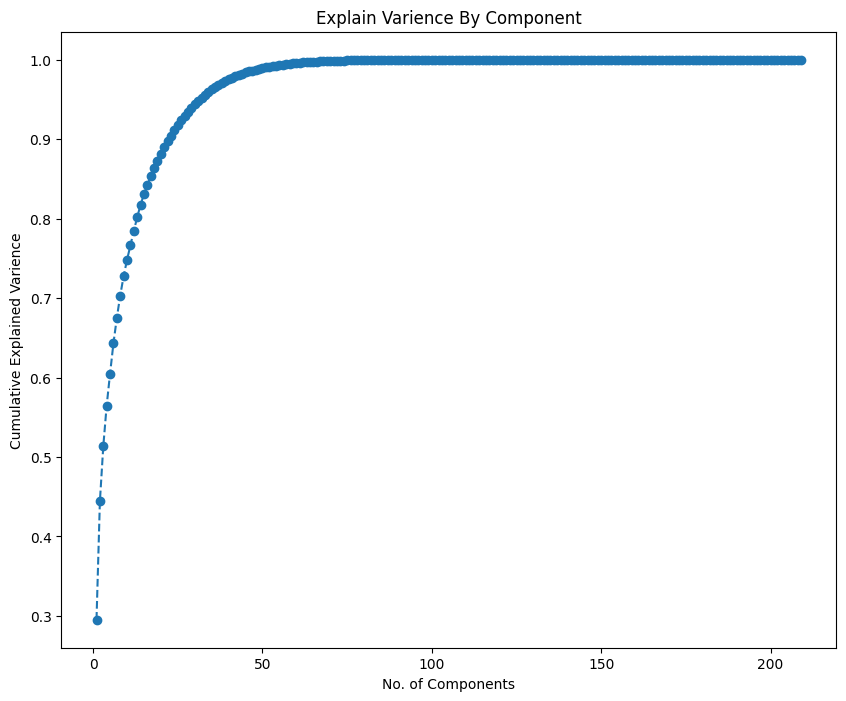

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(range(1,210), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
plt.title('Explain Varience By Component')
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Explained Varience')

**MiniBatch KMeans**

In [ ]:
from sklearn.cluster import MiniBatchKMeans

Optimize n cluster without PCA

c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cl

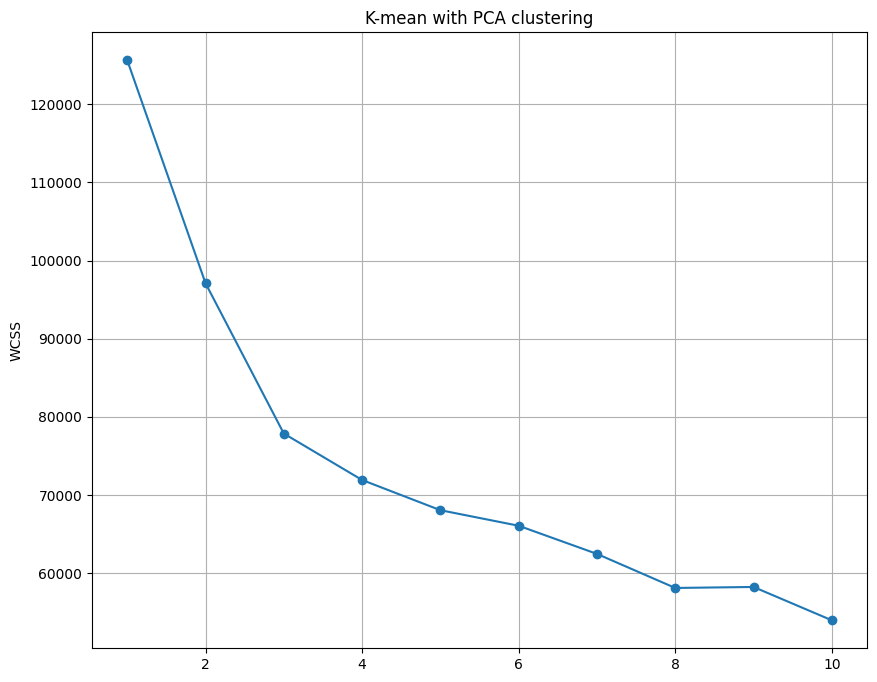

In [ ]:
wcss = []
for i in range(1,11):
    mbk_pca = MiniBatchKMeans(n_clusters=i)
    mbk_pca.fit(X) #X represent entire datasets with all PCA component
    wcss.append(mbk_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, 'o-')
plt.ylabel('WCSS')
plt.grid(True)
plt.title('K-mean with PCA clustering')
plt.show()

Silhouette Method

In [ ]:
#import sklearn.cluster as cluster
#import sklearn.metrics as metrics
#from sklearn.metrics import silhouette_score


In [ ]:
#silhouette_score(X_pca, mbk_pca.labels_)

In [ ]:
#labels = [MiniBatchKMeans(n_clusters=i).fit(X_pca) for i in range(1,10)]
#silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in labels[1:]]
#silhouette_scores

**Clustering K-Means Using PCA**

In [ ]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [ ]:
pca.explained_variance_ratio_

array([0.29525792, 0.14902365, 0.06908986])

In [ ]:
X_pca = pca.transform(X)
X_pca.shape

(766, 3)

Kmeans with PCA

c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cl

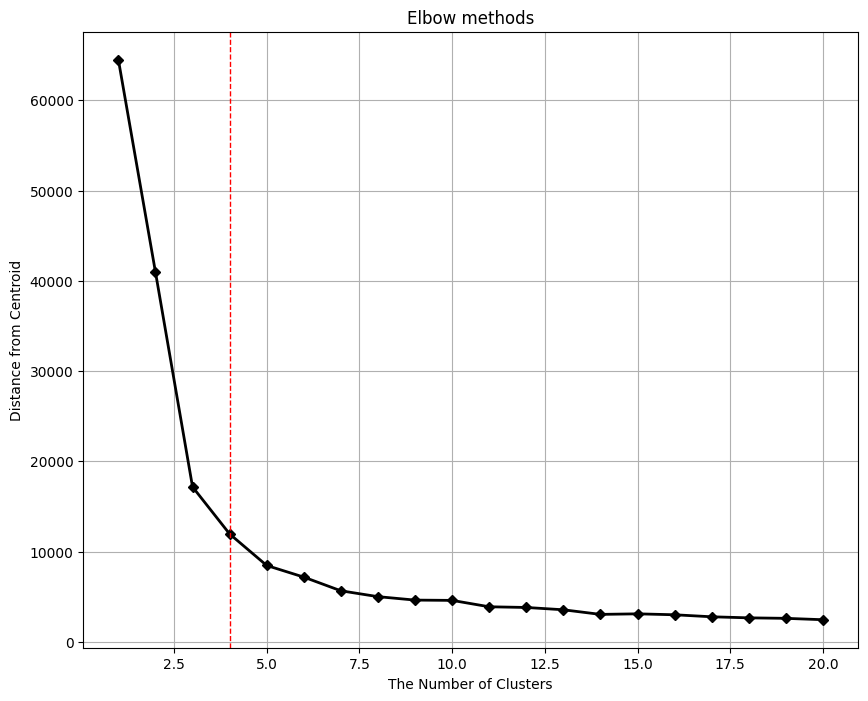

In [ ]:
wcss = []
for i in range(1,21):
    mbk_pca = MiniBatchKMeans(n_clusters=i)
    mbk_pca.fit(X_pca)
    wcss.append(mbk_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,21), wcss, linewidth = 2, color = 'black', marker = 'D', markersize = '5')
plt.xlabel('The Number of Clusters')
plt.ylabel('Distance from Centroid')
plt.grid(True)
plt.title('Elbow methods')
plt.axvline(x = 4, linewidth = 1, color = 'red', linestyle = '--')
plt.show()

In [ ]:
df_pca_mbk = pd.concat([IC50_only, pd.DataFrame(X_pca)], axis=1)
for i in range(1, 4):
    df_pca_mbk.rename(columns={df_pca_mbk.columns[-i]: f'PCA{4 - i}'}, inplace=True)


for k in range (1,11):
    mbk_pca = MiniBatchKMeans(n_clusters=k)
    mbk_pca.fit(X_pca)
    df_pca_mbk[f'MBKMeans_{k}'] = mbk_pca.labels_
    
df_pca_mbk
    

c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cl

,smiles,activity,type,value (nM),pIC50,Structure,PCA1,PCA2,PCA3,MBKMeans_1,MBKMeans_2,MBKMeans_3,MBKMeans_4,MBKMeans_5,MBKMeans_6,MBKMeans_7,MBKMeans_8,MBKMeans_9,MBKMeans_10
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,11.180456,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-1.477077,-4.953304,-2.687820,0,0,2,0,1,0,5,1,1,3
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,11.080922,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-1.477077,-4.953304,-2.687820,0,0,2,0,1,0,5,1,1,3
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,11.070581,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,1.975316,-3.623162,0.949985,0,0,2,0,1,0,0,4,8,1
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,11.055517,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,4.332795,-1.462178,3.366401,0,0,2,0,4,4,0,7,8,1
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,11.040959,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-0.828305,-4.638888,-2.350317,0,0,2,0,1,0,5,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(F)cc4F)CC3)c(N[C@H...,Unspecified,IC50,97800.0000,4.009661,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,0.849961,-4.126484,3.571188,0,0,2,0,1,0,0,4,4,1
762,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,4.008774,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,-0.273892,-4.571452,1.495131,0,0,2,0,1,0,5,4,4,8
763,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.053177,7.366289,-0.861158,0,1,1,2,0,2,2,0,2,9
764,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.036388,7.291503,-0.786930,0,1,1,2,0,2,2,0,2,9


Scatter Plot

In [ ]:
! pip install plotly==5.15.0
import plotly.express as px
import seaborn as sns

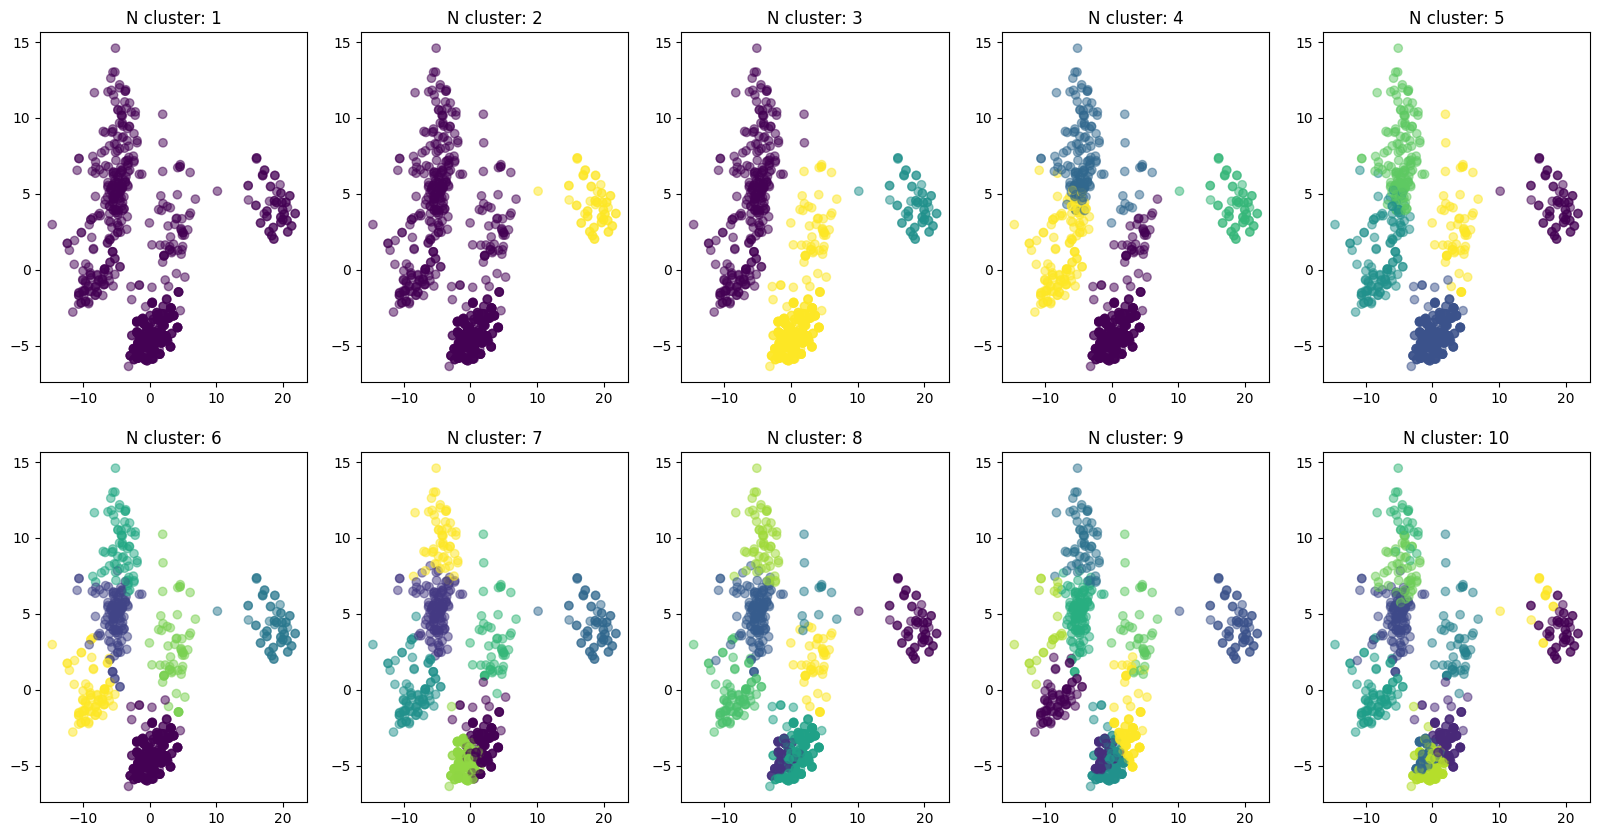

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df_pca_mbk['PCA1'], y=df_pca_mbk['PCA2'], c=df_pca_mbk[f'MBKMeans_{i}'], alpha=0.5)
    ax.set_title(f'N cluster: {i}')


Customize PCA component

In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(X)

PCA(n_components=2)

In [ ]:
X_pca2 = pca2.transform(X)
X_pca2.shape

(766, 2)

In [ ]:
df_pca_mbk2 = pd.concat([IC50_only, pd.DataFrame(X_pca2)], axis=1)
for i in range(1, 3):
    df_pca_mbk2.rename(columns={df_pca_mbk2.columns[-i]: f'PCA{3 - i}'}, inplace=True)



for k in range (1,11):
    mbk_pca2 = MiniBatchKMeans(n_clusters=k, random_state=42)
    mbk_pca2.fit(X_pca2)
    df_pca_mbk2[f'MBKMeans_{k}'] = mbk_pca2.labels_
    
df_pca_mbk2

c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\SPoomYY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cl

,smiles,activity,type,value (nM),pIC50,Structure,PCA1,PCA2,MBKMeans_1,MBKMeans_2,MBKMeans_3,MBKMeans_4,MBKMeans_5,MBKMeans_6,MBKMeans_7,MBKMeans_8,MBKMeans_9,MBKMeans_10
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,11.180456,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-1.477077,-4.953304,0,0,1,0,1,4,4,0,5,5
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,11.080922,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-1.477077,-4.953304,0,0,1,0,1,4,4,0,5,5
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,11.070581,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,1.975316,-3.623162,0,0,1,0,1,1,1,6,1,0
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,11.055517,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,4.332795,-1.462178,0,0,1,0,4,1,6,6,1,8
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,11.040959,<rdkit.Chem.rdchem.Mol object at 0x0000027526D...,-0.828305,-4.638888,0,0,1,0,1,4,4,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(F)cc4F)CC3)c(N[C@H...,Unspecified,IC50,97800.0000,4.009661,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,0.849961,-4.126483,0,0,1,0,1,4,1,6,1,0
762,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,4.008774,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,-0.273892,-4.571452,0,0,1,0,1,4,4,0,5,5
763,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.053177,7.366289,0,0,2,1,0,2,2,1,8,2
764,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000027526E...,16.036388,7.291503,0,0,2,1,0,2,2,1,8,2


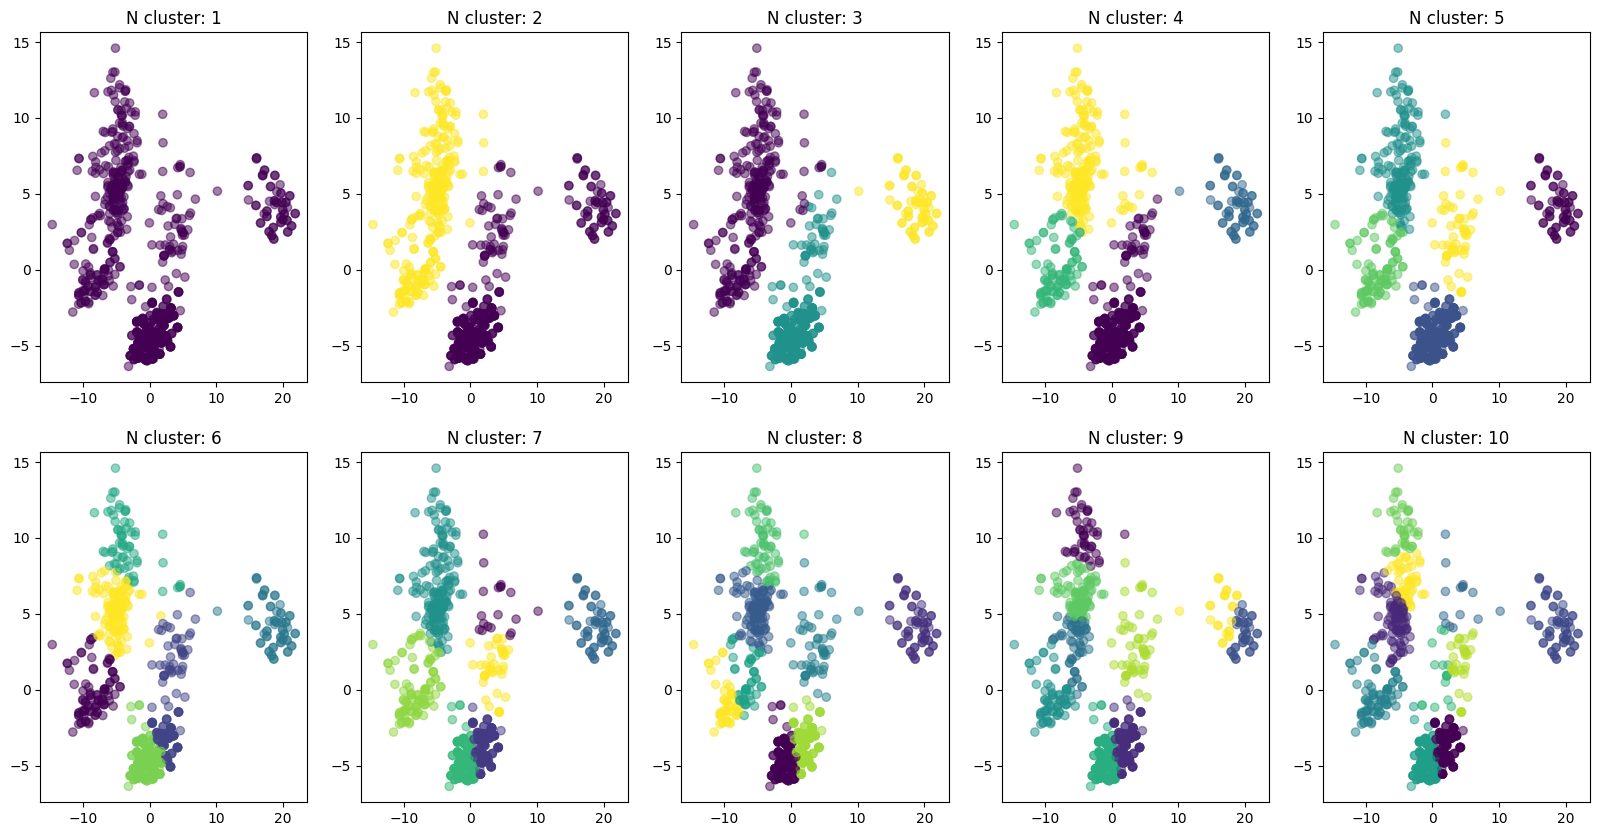

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df_pca_mbk2['PCA1'], y=df_pca_mbk2['PCA2'], c=df_pca_mbk2[f'MBKMeans_{i}'], alpha=0.5)
    ax.set_title(f'N cluster: {i}')

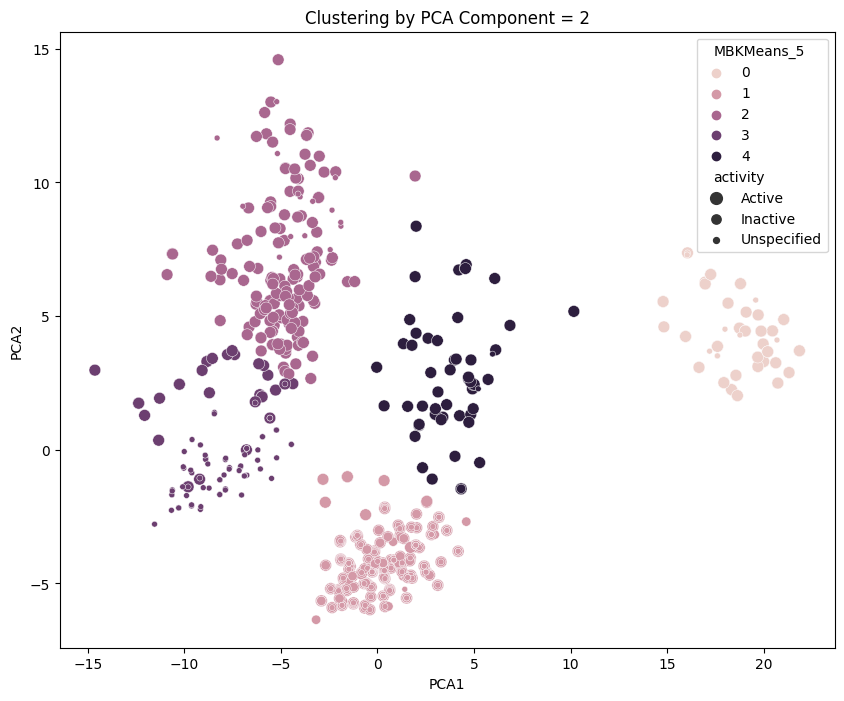

In [ ]:
plt.figure(figsize = (10,8))
sns.scatterplot(df_pca_mbk2, x='PCA1', y='PCA2', hue='MBKMeans_5', size='activity')
plt.title('Clustering by PCA Component = 2')
plt.show()

In [ ]:
#fig = px.scatter_3d(df_pca_mbk2, x='PCA1', y='PCA2', z='PCA3', color='MBKMeans_3')
#fig.show()

**Regression Methods**